For basic information see
 
https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo

https://en.wikipedia.org/wiki/Rejection_sampling

A simple Markov chain Monte-Carlo simulation to generate samples from t-distribution with $2$ degrees of freedom
( target distribution ). I have implemented a random walk Metroplois-Hastings algorithm where I have used a uniform distribution on some intervals $(-\delta , \delta)$ to simulate the walks. 

We have two parameters in the simulation: $\delta$ and $x_0$ ( where to start walking ). Since the target distribution has a density which is symmetric about $0$, so it's reasonable to choose $x_0=0$. Moreover we can expect that if $\delta$ is chosen very small, it takes longer ( needs more simulations ) to see a good estimation. Because our target distribution produces samples which are most likely in interval $(-7.5,7.5)$, therefore if $\delta$ is small, we have small jumps at each step and so we need more simulations to make sure the we have enough samples that cover this interval. On the other hand if $\delta$ is very large, it's more likely to have big jumps and so there is a decent chance that acceptance ratio becomes zero for many subsequent steps and this means we may not update a sample for a long time and this affects the accuracy of simulations.

I have shown how the estimation accuracy changes with $\delta$. In the plots, true density is the density of $t$-distribution with $2$ degrees of freedom.

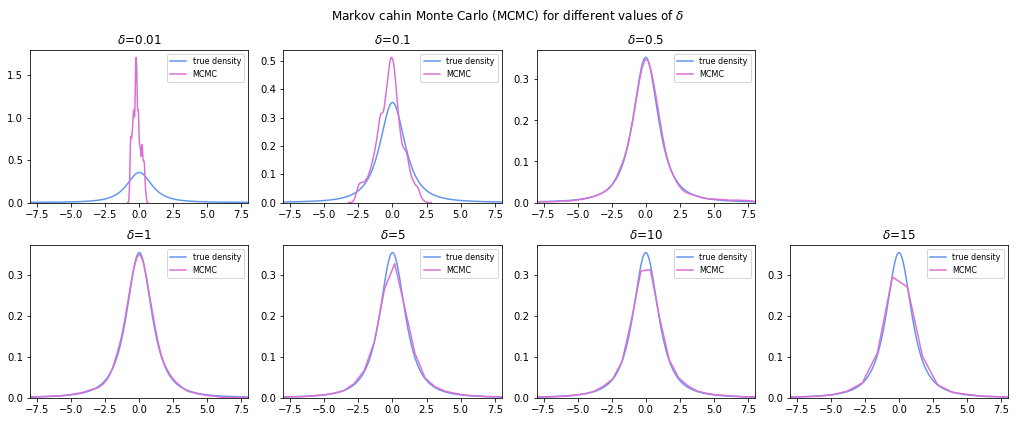

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.stats import t,norm


def Markov_Monte_Carlo(x0, delta, n_samples):
    
    x = np.zeros(n_samples)  # samples
    x[0] = x0
    
    for i in range(1,n_samples):
        
        r = np.random.uniform(-delta,delta)
        y = x[i-1] + r
        acc_ratio = min(np.log(t.pdf(y,2))-np.log(t.pdf(x[i-1],2)) , 0)  # acceptance ratio
        u = np.random.uniform(0,1)
        if np.log(u) <= acc_ratio:
            x[i] = y
        else:
            x[i] = x[i-1]
     
    return x


def MCMC_Plots(x0, delta_vec, n_samples):
    
    half = len(delta_vec)//2
    
    fig1 = plt.figure(figsize=(14,8), constrained_layout=True)
    gs1 = fig1.add_gridspec(3,4)

    for i, delta in enumerate(delta_vec[:half]):  
        
        ax = fig1.add_subplot(gs1[0, i]) 
        
        samples = Markov_Monte_Carlo(x0, delta, n_samples)
        xx = np.linspace(-8,8,n_samples)
        ax.plot(xx, t.pdf(xx,2), label='t-distribution', color='cornflowerblue')
        sns.kdeplot(samples, label='Metropolis simulations', color='orchid', ax=ax)
        ax.set_xlim([-8,8])
        ax.set_title('$\delta$={}'.format(delta))
        ax.legend(['true density','MCMC'], fontsize=8)
        fig1.suptitle('Markov cahin Monte Carlo (MCMC) for different values of $\delta$')
    
        
    for i, delta in enumerate(delta_vec[half:]):  

        ax = fig1.add_subplot(gs1[1, i]) 
        
        samples = Markov_Monte_Carlo(x0, delta, n_samples)
        xx = np.linspace(-8,8,n_samples)
        ax.plot(xx, t.pdf(xx,2), label='t-distribution', color='cornflowerblue')
        sns.kdeplot(samples, label='Metropolis simulations', color='orchid', ax=ax)
        ax.set_xlim([-8,8])
        ax.set_title('$\delta$={}'.format(delta))
        ax.legend(['true density','MCMC'], fontsize=8)
        
   
        
n_samples = 50000
x0 = 0
delta_vec = [0.01, 0.1, 0.5, 1, 5, 10, 15]

MCMC_Plots(x0, delta_vec, n_samples)


As we can see from the plots after sampling of $50000$ samples, the simulation with $\delta=1$ produces the best estimation and accuracy decreases when $\delta$ is chosen very large. For the small values of $\delta$, we need to continue the simulations until we get a close approximation.


In the next cell I have implemented a different method for sampling from t-distribution with $2$ degrees of freedom. This time I have used the rejection sampling method. I have chosen a normal distribution as the candidate density and reject or accept its samples at each step with a specific probability. Here we have 3 parameters: mean and variance of normal distribution ( candidate density ) and $c$ where probability of acceptance is proportional to $\frac{1}{c}$. There are two approaches to deal with parameter $c$. In the first approach $c$ is chosen as $\sup \frac{f(x)}{g(x)}$ where $f$ and $g$ are candidate and target density respectively or alternatively we can start from a initial value for $c$ and update it when we accept a sample. It can be shown that in the second approach after some steps the value of $c$ converges to the value we use for the first approach, i.e. $\sup \frac{f(x)}{g(x)}$, therefore someone might find it more convenient to use the second algorithm in rejection sampling method and not bother themselves finding the supremum of that quotient. 

In the next cell however, I have done an experiment on different values of $c$ to see how it affects the accuracy of simulations. Since $t$-distribution has mean $0$, so I have chosen $\mu=0$ for the mean of normal distribution. I have also used different values for $\sigma^2$, variance of normal distribution.

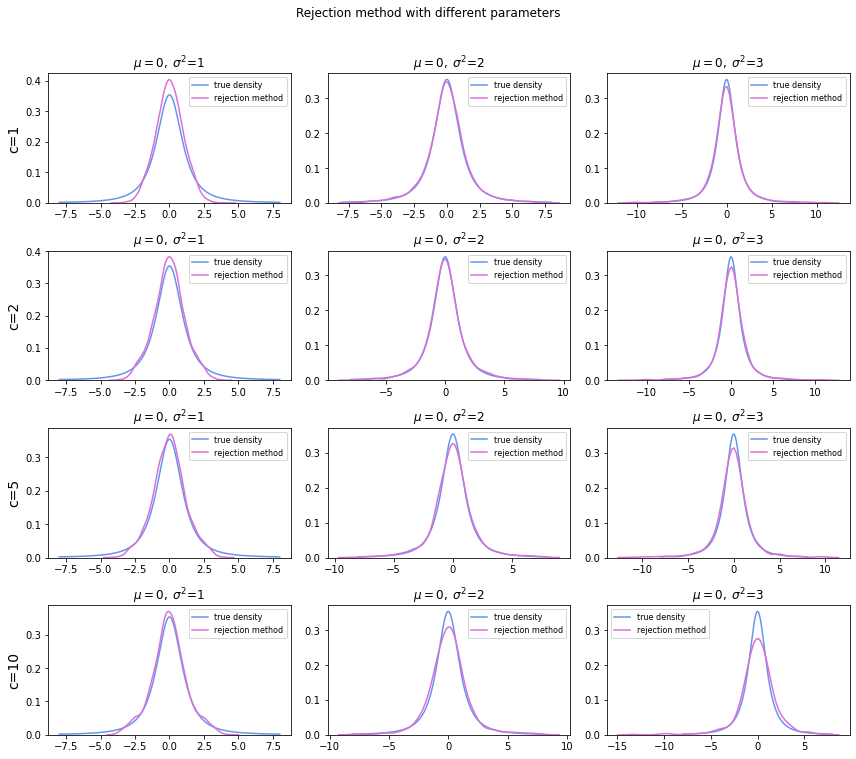

In [48]:


def rejection_sampling(mu, v, c, n_samples):
    
    accepted_samples=[]
    
    for i in range(n_samples):  
        
        u = np.random.uniform(0,1)    # or u = uniform.rvs(size=1, loc = 0, scale=1)
        n = np.random.normal(mu, v, 1)[0]    # or n = norm.rvs(size=1,loc=0,scale=1)

        if u < (t.pdf(n,2))/(c*norm.pdf((n-mu)/v)): 
            accepted_samples.append(n) 
            
    return accepted_samples



def rs_plots(n_samples, mu, var_vec, c_vec):
    
    fig, ax = plt.subplots(len(c_vec),len(var_vec),figsize=(12,10))
    xx = np.linspace(-8,8,n_samples)
    
    for i, c in enumerate(c_vec):
         for j, v in enumerate(var_vec):
    
            accepted_samples = rejection_sampling(mu, v, c, n_samples,)
            ax[i,j].plot(xx, t.pdf(xx,2), label='1', color='cornflowerblue')
            sns.kdeplot(accepted_samples, label='2', color='orchid', ax=ax[i,j])
            ax[i,j].set_title('$\mu=0,\;\sigma^2$={}'.format(v),fontsize=12)
            ax[i,0].set_ylabel('c={}'.format(c), fontsize=14)
            ax[i,j].legend(['true density','rejection method'], fontsize=8)
            plt.suptitle('Rejection method with different parameters', y=1.05)
            plt.tight_layout()
            
mu = 0   
n_samples = 20000
c_vec = [1,2,5,10]
var_vec = [1,2,3]

rs_plots(n_samples, mu, var_vec, c_vec)


In the next cell I have campared rejection method where I have found and fixed $c = \sup \frac{f(x)}{g(x)}$ and the alternative method where I started with an initial value $c_0 =1$ and updated the value of $c$ during the simulation. We can see from the plots that in the second approach, after some steps, $c$ converges to $\sup \frac{f(x)}{g(x)}.$

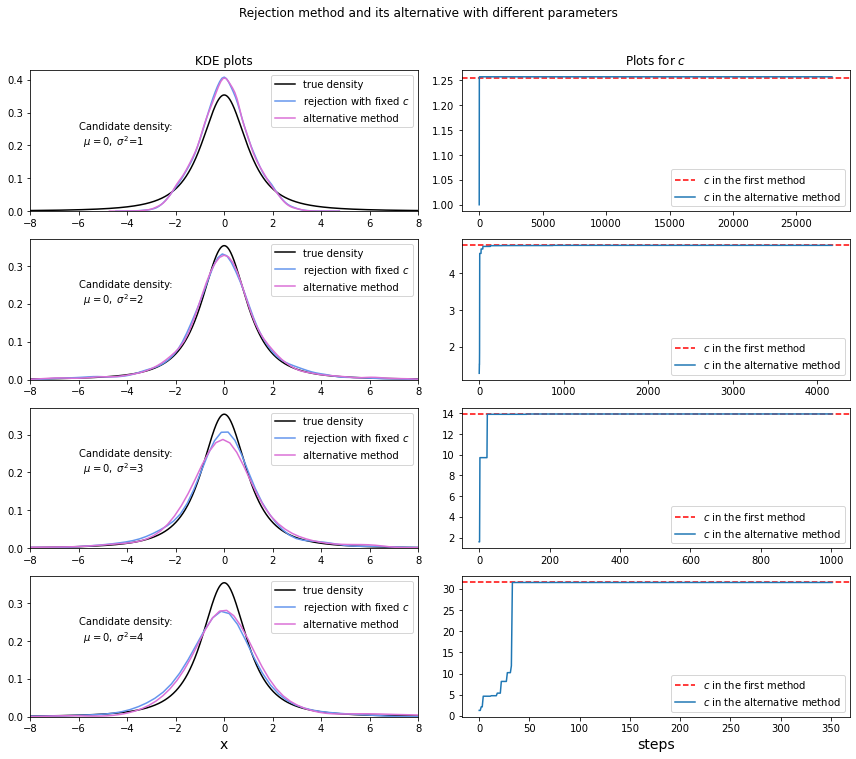

In [83]:
def supremum(mu, v):
    
    x = np.linspace(-10,10,100)
    q = norm.pdf((x-mu)/v) / t.pdf(x,2)
    sup = max(q)
    return sup



def rejection_method1(mu, v, n_samples):
    
    c = supremum(mu, v)
    sample1=[]
    
    for i in range(n_samples):  
        
        u = np.random.uniform(0,1)    # or u = uniform.rvs(size=1, loc = 0, scale=1)
        n = np.random.normal(mu, v,1)[0]    # or n = norm.rvs(size=1,loc=0,scale=1)

        if u < (t.pdf(n,2))/(c*norm.pdf((n-mu)/v)): 
            sample1.append(n) 
            
    return c, sample1


def rejection_method2(mu, v, c0, n_samples):
    
    c_list = []
    sample2=[]
    c = c0    # initialize c 
    
    for i in range(n_samples):   
        u = np.random.uniform(0,1)    # or u = uniform.rvs(size=1, loc = 0, scale=1)
        n = np.random.normal(mu, v,1)[0]    # or n = norm.rvs(size=1,loc=0,scale=2)
        
        if u < (t.pdf(n, 2))/(c*norm.pdf((n-mu)/v)):  
            sample2.append(n) 
            c = max(c, norm.pdf((n-mu)/v) / t.pdf(n,2))  
            c_list.append(c)
            
    return c_list, sample2    



def comparison_plots(mu, var_vec, c0, n_samples):
    
    fig, ax = plt.subplots(len(var_vec),2, figsize=(12,10))
    xx = np.linspace(-8,8,n_samples)

    for i, v in enumerate(var_vec):

        c, sample1 = rejection_method1(mu, v, n_samples)
        c_list, sample2 = rejection_method2(mu, v, c0, n_samples)
        
        ax[i,0].plot(xx, t.pdf(xx,2), label='1', color='black')
        sns.kdeplot(sample1, label='2', color='cornflowerblue', ax=ax[i,0])
        sns.kdeplot(sample2, label='3', color='orchid', ax=ax[i,0])
        ax[i,0].set_xlim([-8,8])
        ax[0,0].set_title('KDE plots')
        ax[i,0].text(-6,0.2,'Candidate density:\n $\,\mu=0,\;\sigma^2$={}'.format(v))
        ax[i,0].legend(['true density','rejection with fixed $c$','alternative method'], fontsize=10)
        ax[-1,0].set_xlabel('x', fontsize=14)
        
        ax[i,1].axhline(y=c, label='4', color='r', linestyle='--')
        ax[i,1].plot(np.arange(len(c_list)),c_list, label='5')
        ax[0,1].set_title('Plots for $c$', fontsize=12)
        ax[i,1].legend(['$c$ in the first method','$c$ in the alternative method'], fontsize=10)
        ax[-1,1].set_xlabel('steps', fontsize=14)
        
        plt.suptitle('Rejection method and its alternative with different parameters', y=1.05)
        plt.tight_layout()
            
mu = 0   
n_samples = 40000
c0 = 1
var_vec = [1,2,3,4]

comparison_plots(mu, var_vec, c0, n_samples)

We can discuss on above results. As we know from rejection method, the probability of ( unconditional ) acceptance at each steps is $1/c$. For case $\sigma^2 = 1$, we have ( always or after some steps depending on the approach ) $c \approx 1.25$, so the probability of acceptance is high ( about $0.8$ ). On the other hand for cases $\sigma^2=3$ or $\sigma^2=4$, probability of acceptance becomes very low after some steps ( $0.07$ and $0.03$ respectively ) and hence we need much more samples to get a close approximation. For case $\sigma^2 =2$ we have a good approximation after $30000$ steps because probability of acceptance is a bit greater than $0.2$ which is not very low or high.

In the last cell I have compared rejection sampling method with fixed $c = \sup \frac{f(x)}{g(x)}$ and Monte-Carlo Markov chain method. For rejection sampling I have chosen normal density with $\mu=0$ and $\sigma^2=2$ as the candidate density and for MCMC method I have chosen $\delta=1$ for symmetric random walks, because these parameters produced best results in the previous cells.

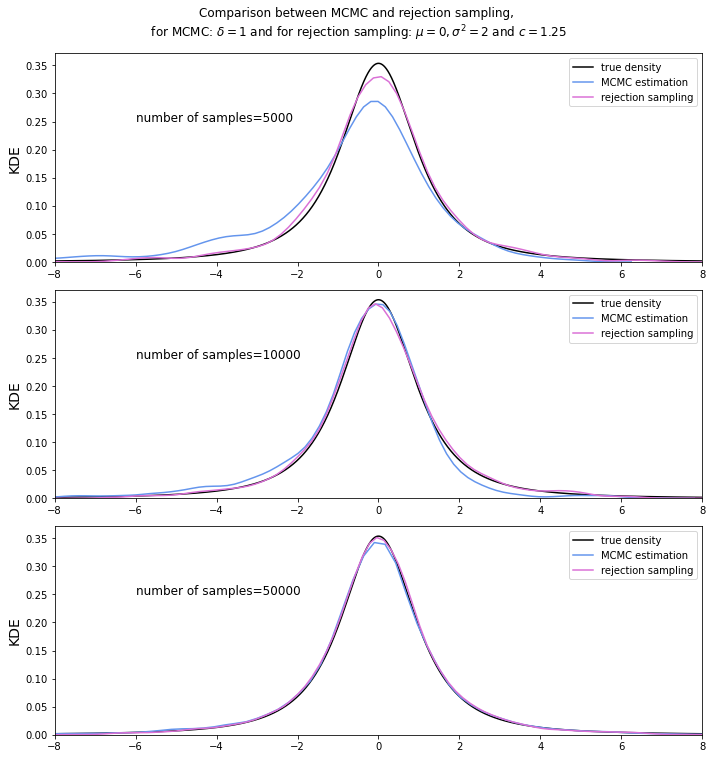

In [80]:


def Markov_Monte_Carlo(x0, delta, n_samples):
    
    x = np.zeros(n_samples)  # samples
    x[0] = x0
    
    for i in range(1,n_samples):
        
        r = np.random.uniform(-delta,delta)
        y = x[i-1] + r
        acc_ratio = min(np.log(t.pdf(y,2))-np.log(t.pdf(x[i-1],2)) , 0)
        u = np.random.uniform(0,1)
        
        if np.log(u) < acc_ratio:
            x[i] = x[i-1] + r
        else:
            x[i] = x[i-1]
     
    return x


def rejection_sampling(mu, v, n_samples):
    
    c = 1.25
    accepted_samples=[]
    
    for i in range(n_samples):   
        u = np.random.uniform(0,1)    # or u = uniform.rvs(size=1, loc = 0, scale=1)
        n = np.random.normal(mu, v,1)[0]    # or n = norm.rvs(size=1,loc=0,scale=1)
        
        if u < (t.pdf(n,2))/(c*norm.pdf((n-mu)/v)):  # probability of acceptance = f(x)/(c g(x))
            accepted_samples.append(n) 
            
    return accepted_samples




def plots(x0, delta, mu, v, s:list):
    
    fig, ax = plt.subplots(len(s), figsize=(10,10))
      
    for i, n_samples in enumerate(s):
        
        o1 = Markov_Monte_Carlo(x0, delta, n_samples)
        o2 = rejection_sampling(mu, v, n_samples)
        xx = np.linspace(-8,8,n_samples) 
        ax[i].plot(xx, t.pdf(xx,2), label='1', color='black')
        sns.kdeplot(o1, label='1', color='cornflowerblue', ax=ax[i])
        sns.kdeplot(o2, label='2', color='orchid', ax=ax[i])
        ax[i].set_xlim([-8,8])
        ax[i].text(-6,0.25,'number of samples={}'.format(n_samples), fontsize=12)
        ax[i].set_ylabel('KDE', fontsize=14)
        ax[i].legend(['true density','MCMC estimation','rejection sampling'], fontsize=10)
        plt.suptitle('Comparison between MCMC and rejection sampling,\n for MCMC:'\
                    ' $\delta=1$ and for rejection sampling: $\mu=0,\sigma^2=2$ and $c=1.25$', y=1.05)
        plt.tight_layout()
    
    
x0 = 0
delta = 1  
mu = 0   
v = 2
s = [5000,10000, 50000]

plots(x0, delta, mu, v, s)

We can see that with a good choice of paramaters for both methods, we have a close approximation after $50000$ simulations.